In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn-dark-palette')
import ROOT
from ROOT import TLorentzVector
data = pd.DataFrame.from_csv('truth.csv')
data = data.apply(pd.to_numeric, errors='coerce')
data.drop(['i1','i2','i3'],inplace=True,axis=1)
data.drop(['X','Y','Z','T'],inplace=True,axis=1)

data['Pt'] = np.sqrt(data.Px**2 + data.Py**2)
data['Phi_x'] = np.arccos(data.Px/data.Pt)
data['Phi_y'] = np.arcsin(data.Py/data.Pt)
data['Theta'] = np.arctan(data.Pt/data.Pz)

Welcome to JupyROOT 6.07/05


In [2]:
pt_smear = 115e-4 # * np.mean(data.Pt)
phi_smear = 1e-4 # * np.mean(data.Phi_x)
theta_smear = 1e-4 # * np.mean(data.Theta)

data['Pt_measure'] = np.random.normal(data.Pt,pt_smear*data.Pt,len(data))
data['Phi_measure'] = np.sign(data.Py)*np.random.normal(data.Phi_x,phi_smear,len(data))
data['Phi_x_measure'] = np.random.normal(data.Phi_x,phi_smear,len(data))
data['Phi_y_measure'] = np.random.normal(data.Phi_y,phi_smear,len(data))
data['Theta_measure'] = np.random.normal(data.Theta,theta_smear,len(data))


#data['Px_measure'] = data.Pt_measure*np.cos(data.Phi_measure)
#data['Py_measure'] = data.Pt_measure*np.sin(data.Phi_measure)

data['Px_measure'] = data.Pt_measure*np.cos(data.Phi_x_measure)
data['Py_measure'] = data.Pt_measure*np.sin(data.Phi_y_measure)
data['Pz_measure'] = data.Pt/np.tan(data.Theta_measure)
data['E_measure'] = np.sqrt(data.Px_measure**2 + data.Py_measure**2 + data.Pz_measure**2)

In [3]:
data.head(10)

event      ID  mother  daughter1  daughter2      Px      Py      Pz  \
part                                                                        
0         0  300553      -1          1          2  0.1760  0.0000  4.4988   
1         1     521       0          3          4  0.4054 -0.1093  2.4376   
2         2    -521       0          9         12 -0.2294  0.1093  2.0612   
3         3     333       1          5          6  2.0084 -1.4483  1.7238   
4         4   10321       1          7          8 -1.6030  1.3390  0.7138   
5         5     321       3         32         34  1.2486 -0.9178  1.0902   
6         6    -321       3         35         37  0.7598 -0.5305  0.6336   
7         7     310       4         38         39 -1.6694  0.7277  0.3581   
8         8     211       4         40         43  0.0664  0.6113  0.3558   
9         9     421       2         13         16  0.0409 -0.1006  1.3949   

            E        Pt    ...         Theta  Pt_measure  Phi_measure  \
part                       ...                                          
0     11.5028  0.176000    ...      0.039102    0.172985     0.000000   
1      5.8299  0.419876    ...      0.170576    0.417250    -0.263216   
2      5.6729  0.254108    ...      0.122663    0.254040     2.696928   
3      3.1843  2.476135    ...      0.962648    2.503558    -0.624850   
4      2.6456  2.088667    ...      1.241491    2.046931     2.445699   
5      1.9580  1.549632    ...      0.957711    1.526147    -0.633989   
6      1.2263  0.926675    ...      0.971070    0.939446    -0.609595   
7      1.9216  1.821111    ...      1.376635    1.818865     2.730379   
8      0.7240  0.614896    ...      1.046235    0.608915     1.462525   
9      2.3313  0.108596    ...      0.077696    0.109629    -1.184766   

      Phi_x_measure  Phi_y_measure  Theta_measure  Px_measure  Py_measure  \
part                                                                        
0         -0.000039       0.000083       0.038955    0.172985    0.000014   
1          0.263254      -0.263453       0.170631    0.402875   -0.108658   
2          2.696883       0.444768       0.122761   -0.229331    0.109300   
3          0.625047      -0.624862       0.962683    2.030225   -1.464544   
4          2.445738       0.695951       1.241542   -1.571032    1.312319   
5          0.633952      -0.633764       0.957612    1.229605   -0.903756   
6          0.609489      -0.609400       0.971345    0.770290   -0.537716   
7          2.730544       0.411030       1.376582   -1.667358    0.726735   
8          1.462517       1.462698       1.046319    0.065804    0.605361   
9          1.184616      -1.184646       0.077718    0.041292   -0.101557   

      Pz_measure  E_measure  
part                         
0       4.515728   4.519040  
1       2.436790   2.472258  
2       2.059532   2.075141  
3       1.723674   3.039367  
4       0.713681   2.167871  
5       1.090428   1.875563  
6       0.633227   1.132899  
7       0.358201   1.853790  
8       0.355730   0.705221  
9       1.394491   1.398794  

[10 rows x 22 columns]

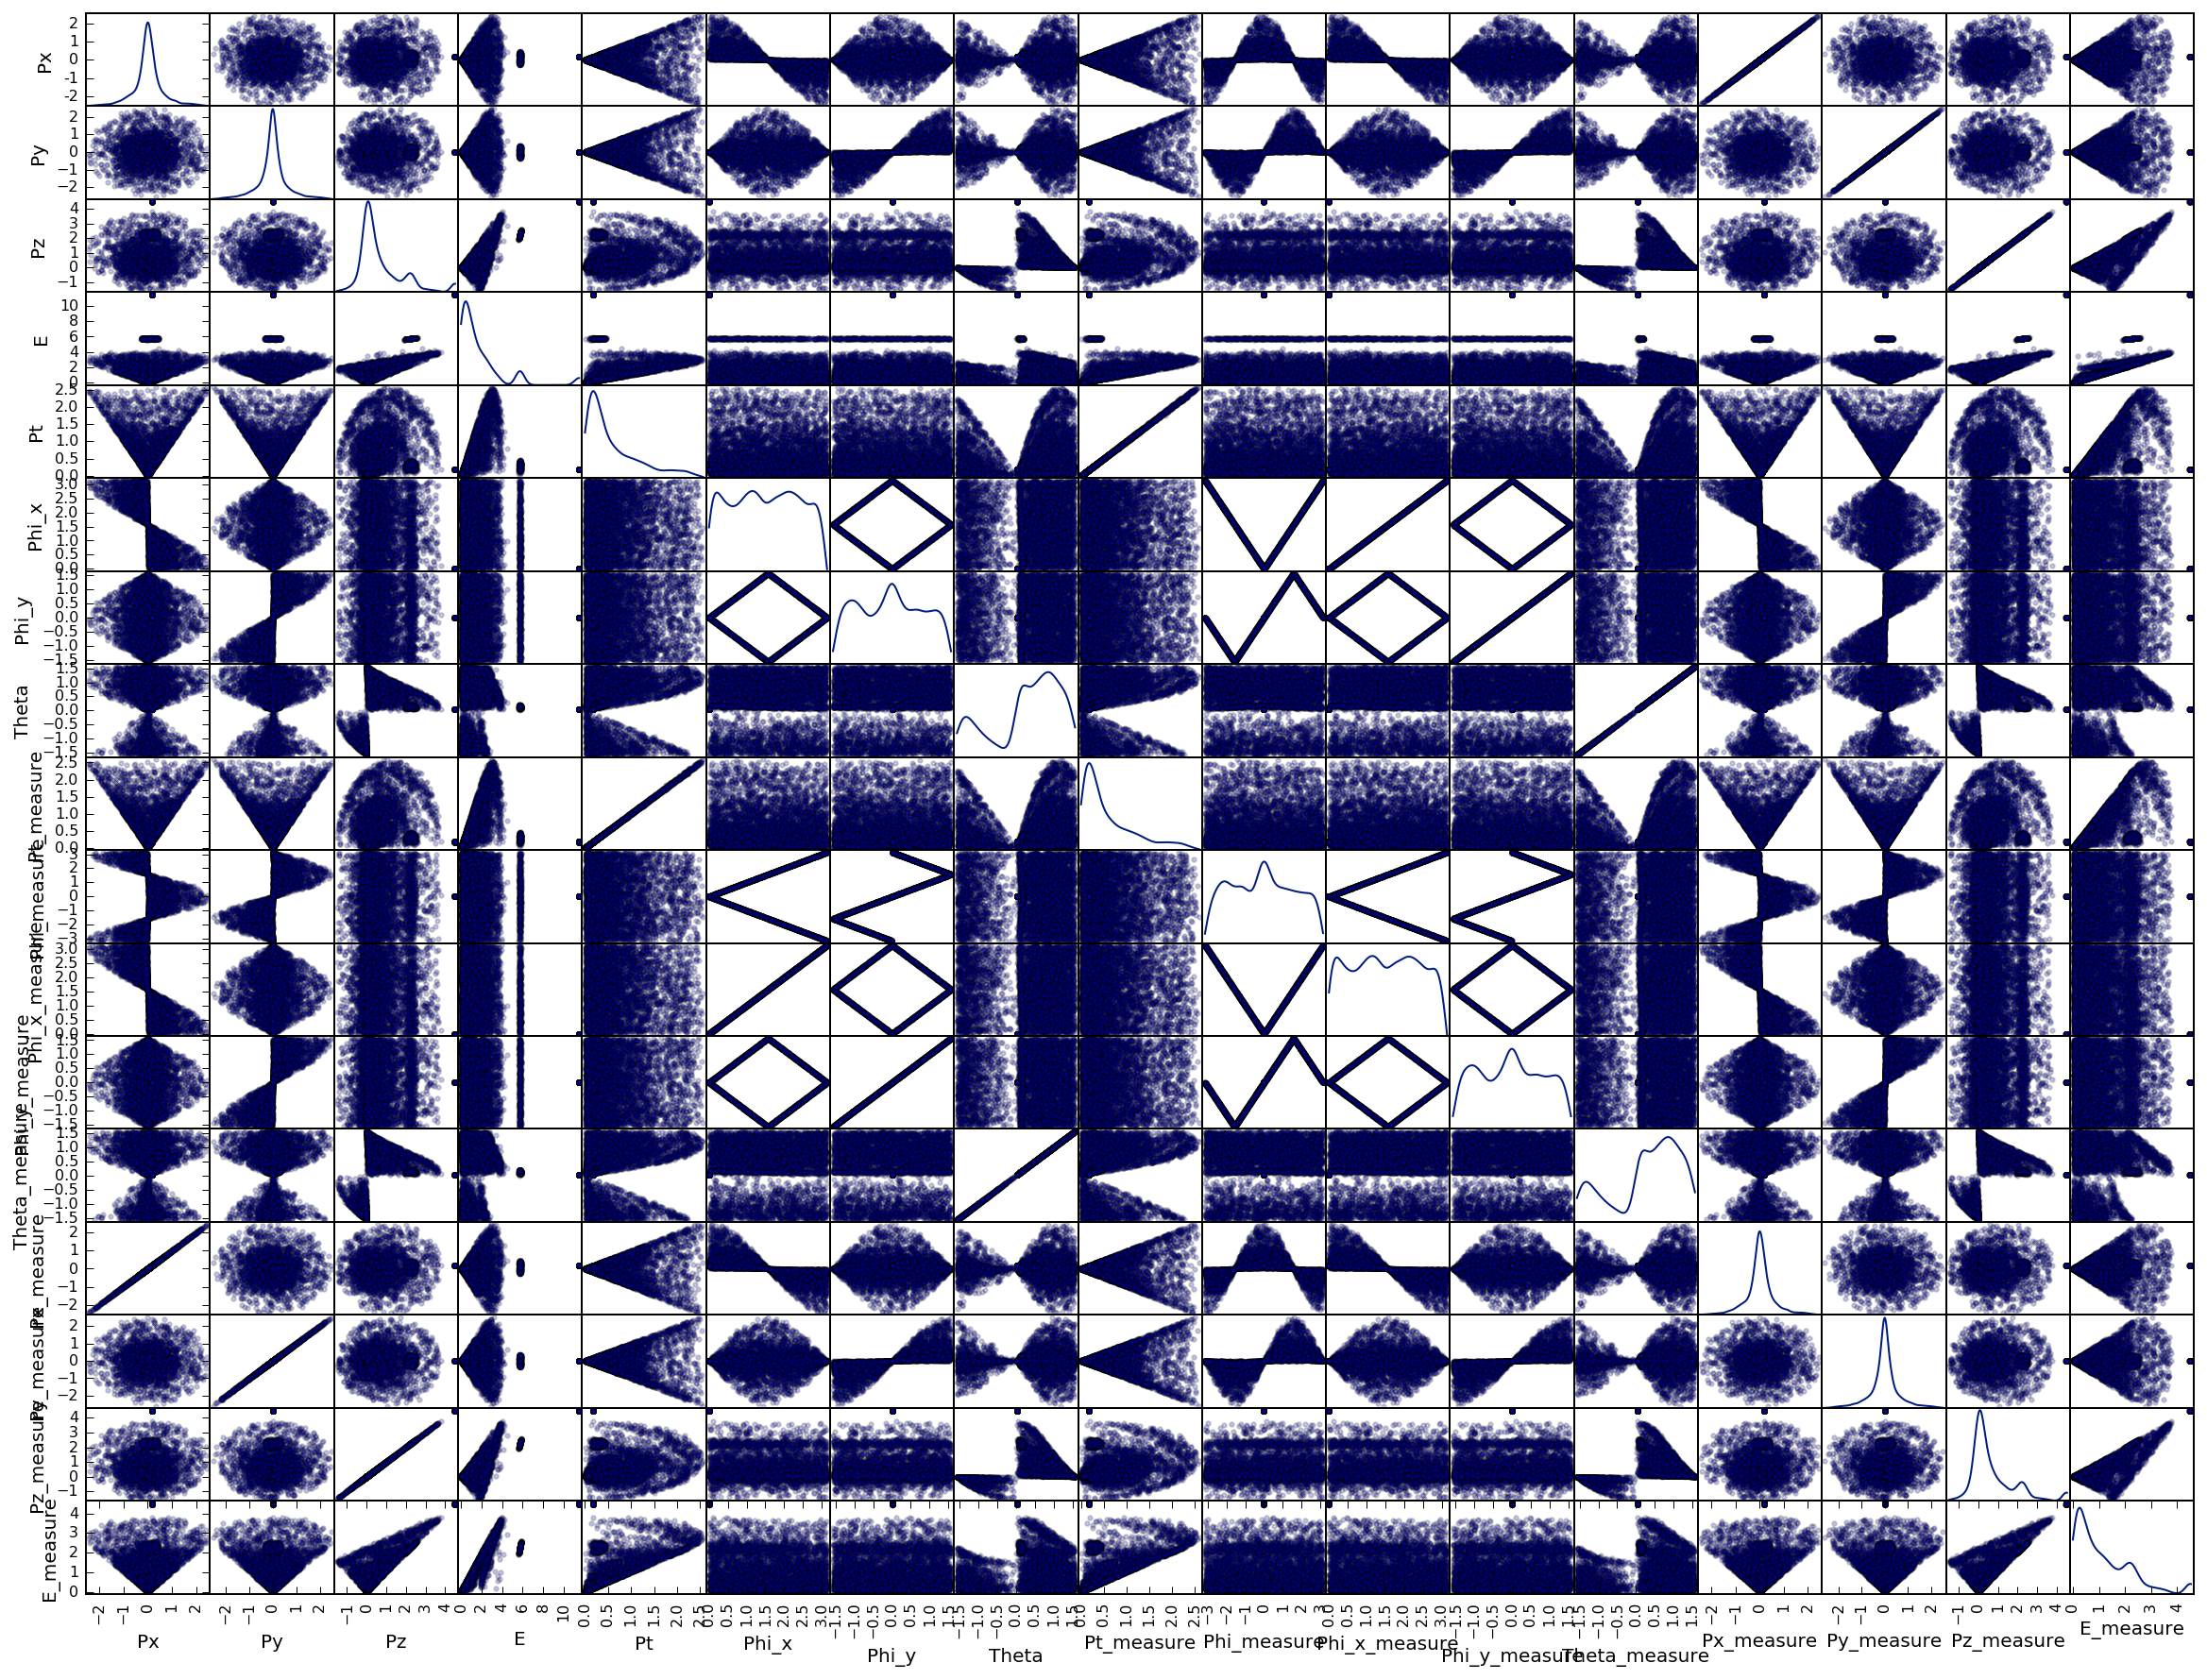

In [4]:
kin = data.drop(['event','ID','mother','daughter1','daughter2'],axis=1)
ax = scatter_matrix(kin, alpha=0.2, figsize=(20, 15),diagonal='kde')

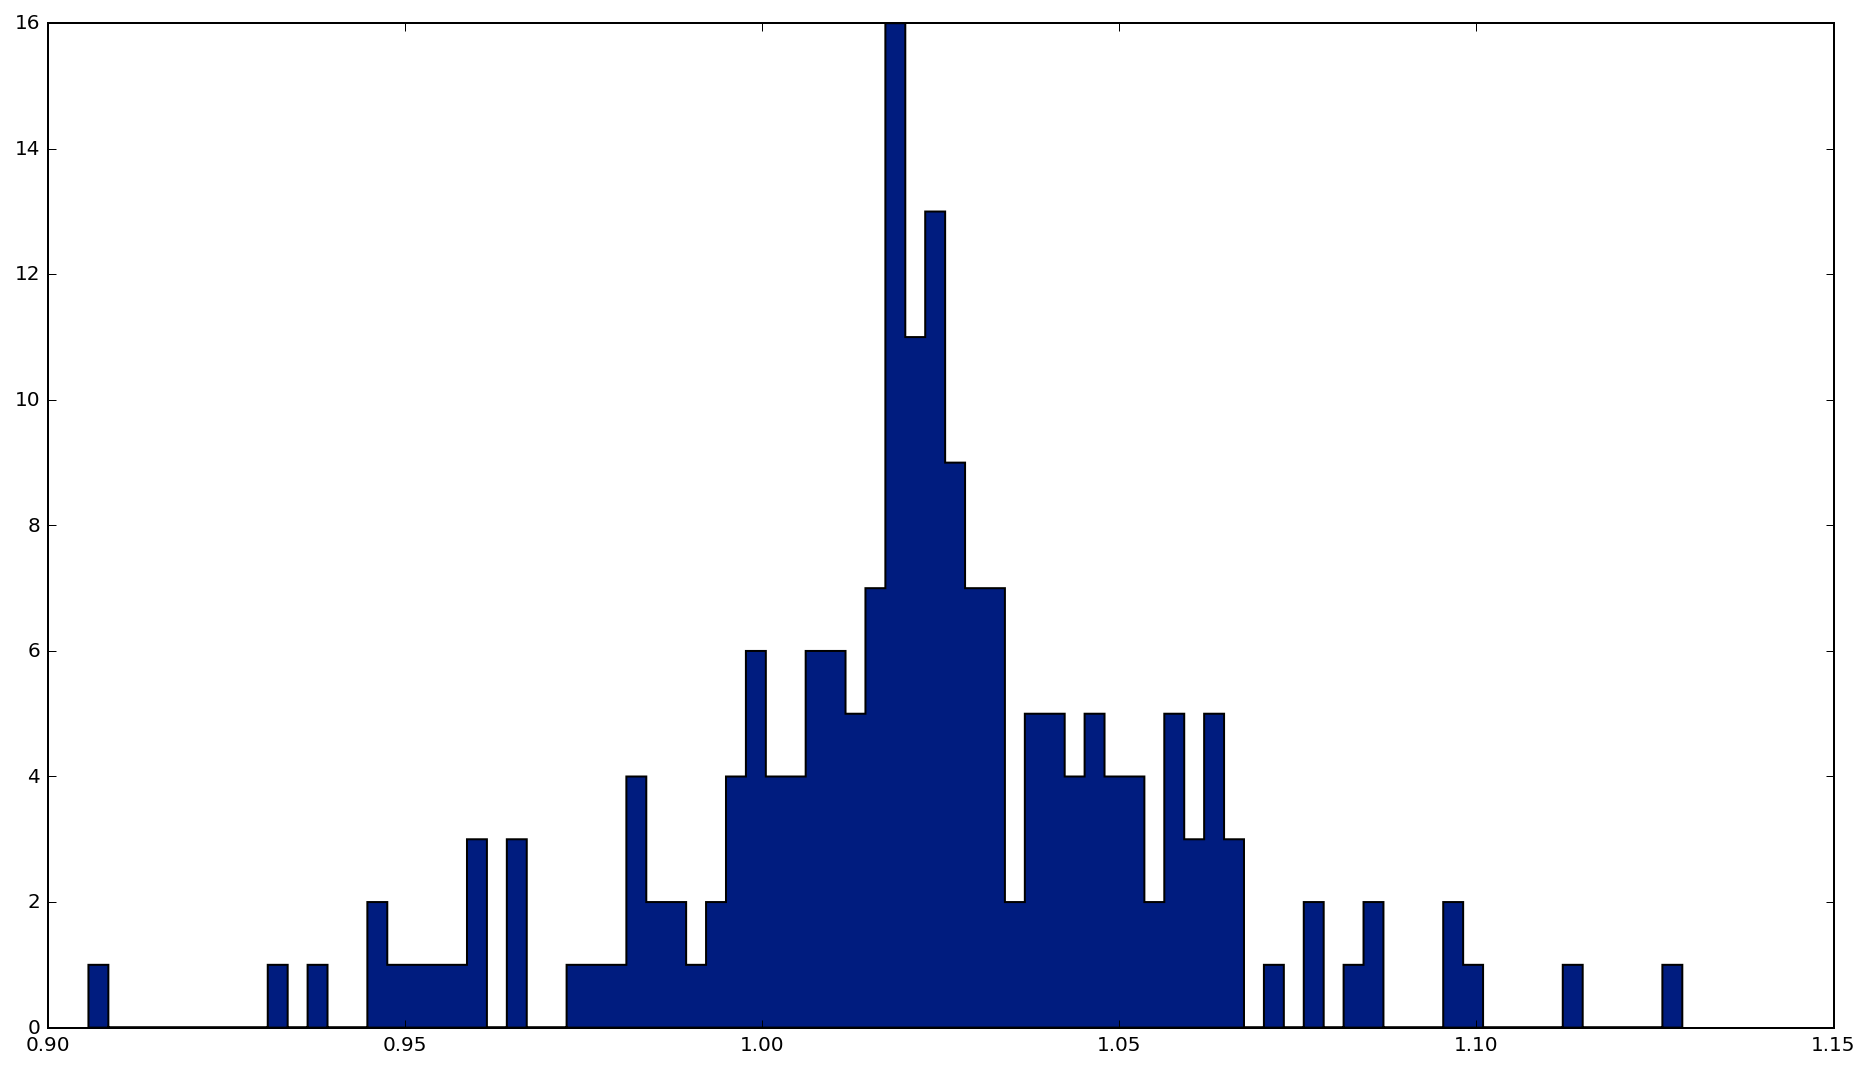

In [5]:
events = pd.DataFrame()
mom = 0
phi_mass = []
temp = TLorentzVector(0,0,0,0)
for index, row in data.iterrows():
    if row.ID == 333:
        if temp.M() != 0 and temp.M() < 1.2:
            phi_mass.append(temp.M())
        temp.SetPxPyPzE(0,0,0,0)
        mom = row['event']
    elif np.abs(row.ID) == 321 and row.mother == mom:
        temp = temp + TLorentzVector(row.Px_measure,row.Py_measure,row.Pz_measure,row.E)
        events = events.append(row)

events = events.apply(pd.to_numeric, errors='coerce')

phi_mass = np.array(phi_mass)

fig = plt.figure(figsize=(16,9))

bins = 80
ax = plt.hist(phi_mass,histtype='stepfilled',bins=bins)

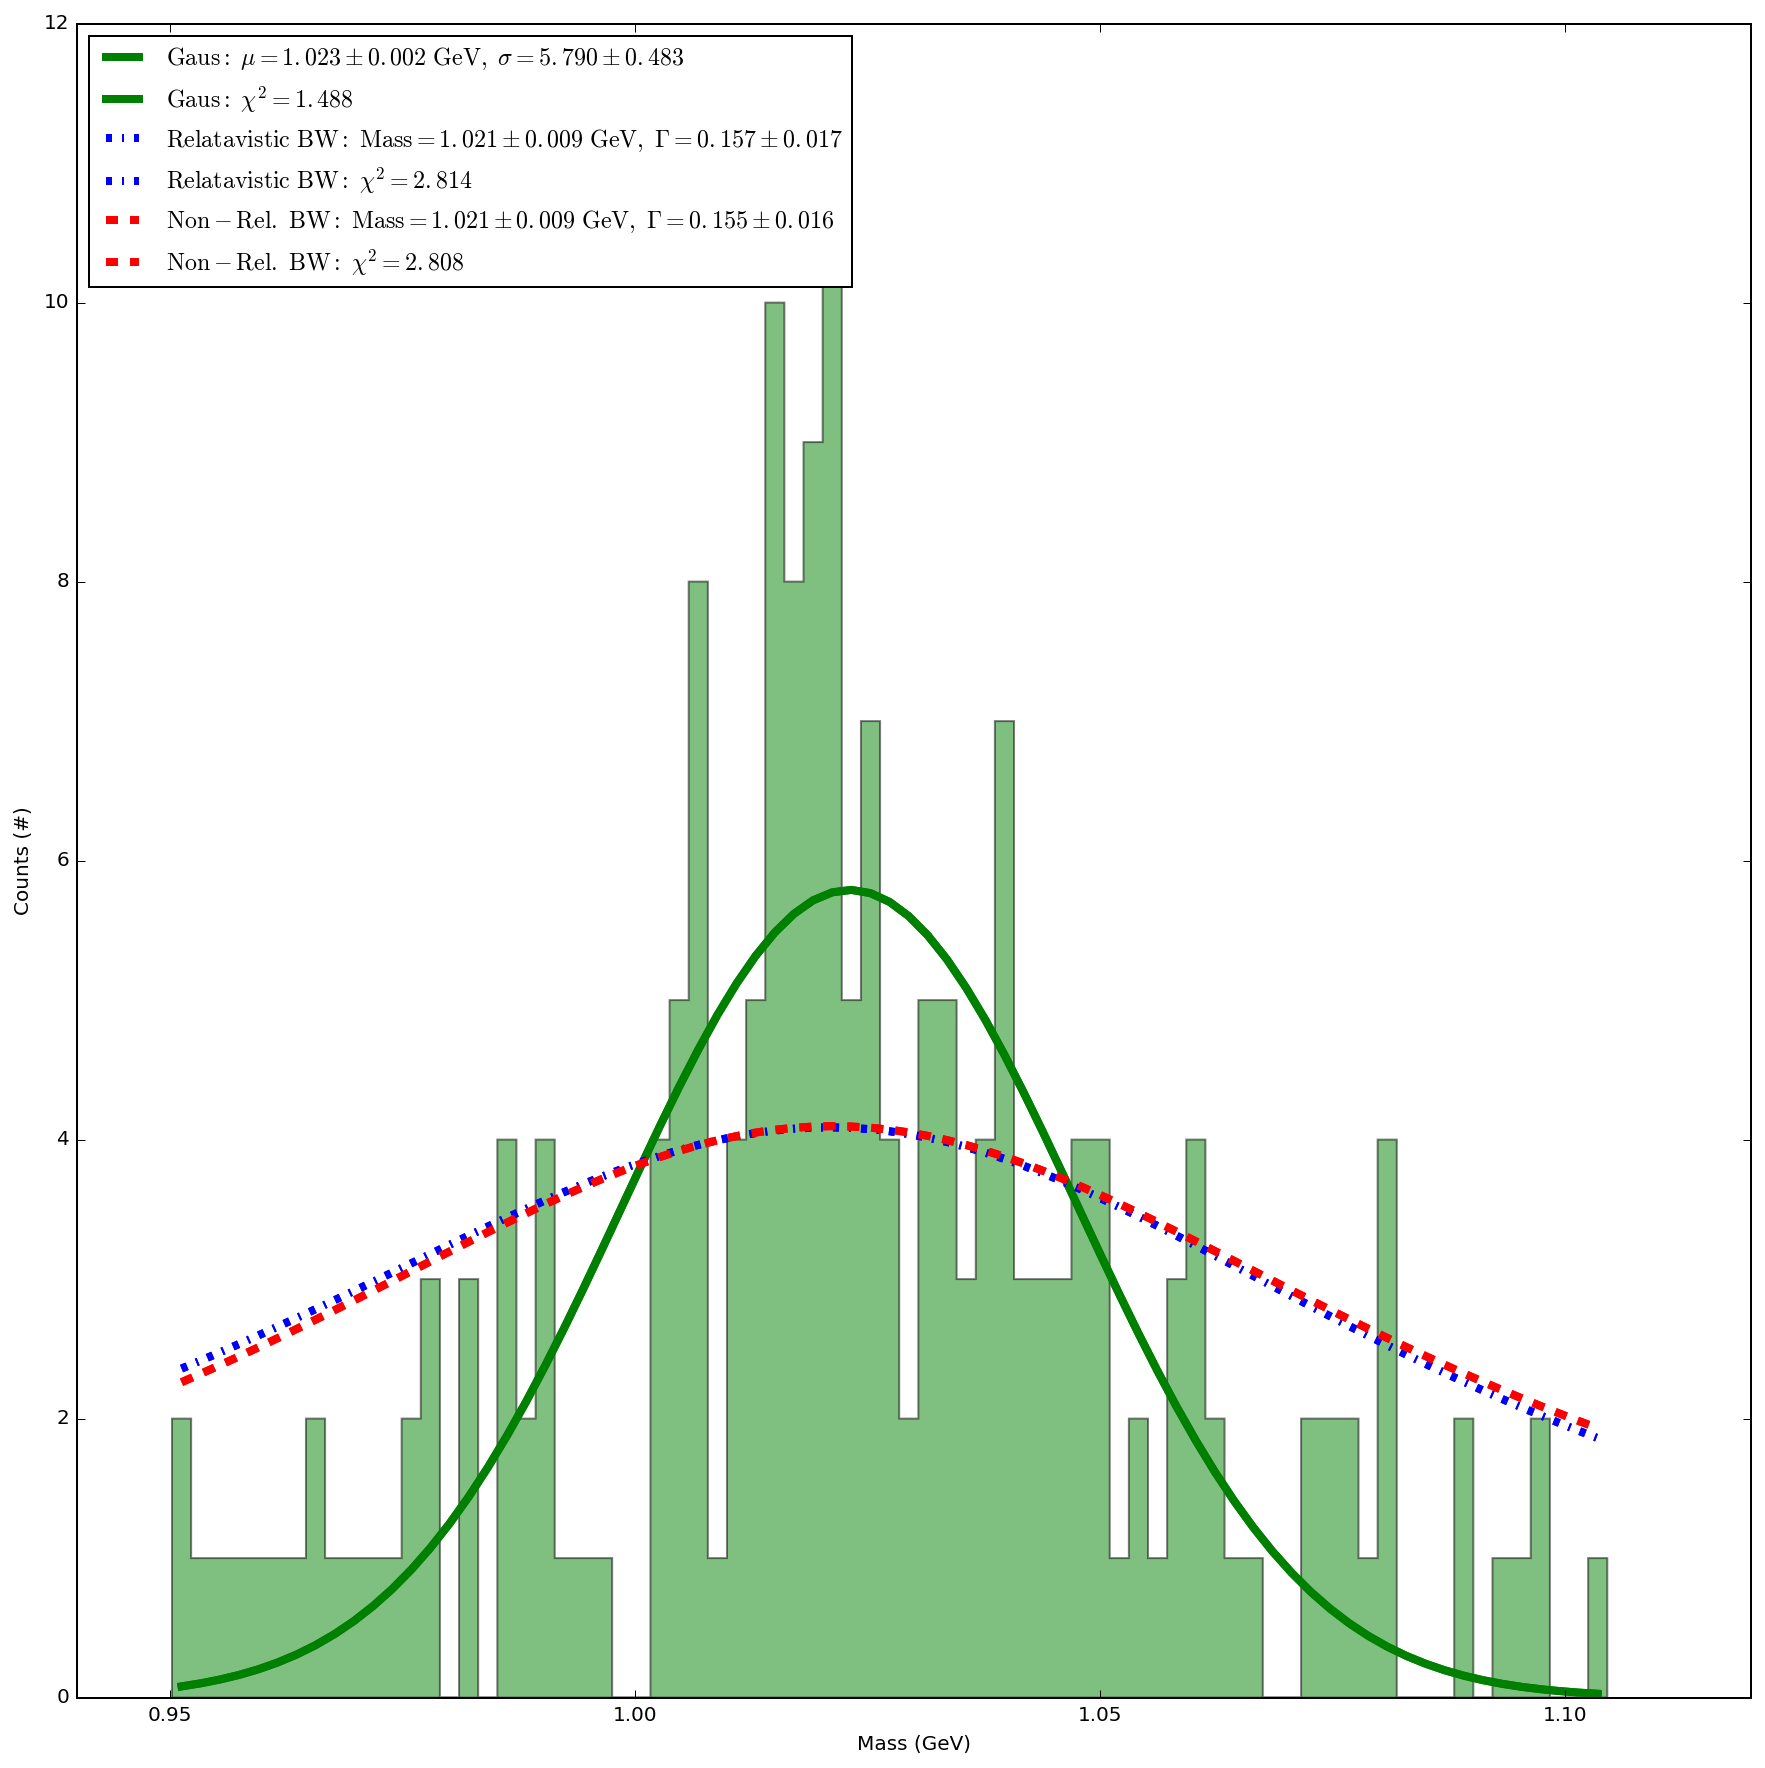

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from StringIO import StringIO
from ROOT import TLorentzVector
from scipy.optimize import curve_fit
import pandas as pd
import ROOT
from ROOT import TLorentzVector
data = pd.DataFrame.from_csv('truth.csv')
data = data.apply(pd.to_numeric, errors='coerce')
data.drop(['i1','i2','i3'],inplace=True,axis=1)
data.drop(['X','Y','Z','T'],inplace=True,axis=1)

data['Pt'] = np.sqrt(data.Px**2 + data.Py**2)
data['Phi_x'] = np.arccos(data.Px/data.Pt)
data['Phi_y'] = np.arcsin(data.Py/data.Pt)
data['Theta'] = np.arctan(data.Pt/data.Pz)

pt_smear = 115e-4 # * np.mean(data.Pt)
phi_smear = 1e-4 # * np.mean(data.Phi_x)
theta_smear = 1e-4 # * np.mean(data.Theta)

data['Pt_measure'] = np.random.normal(data.Pt,pt_smear*data.Pt,len(data))
data['Phi_measure'] = np.sign(data.Py)*np.random.normal(data.Phi_x,phi_smear,len(data))
data['Phi_x_measure'] = np.random.normal(data.Phi_x,phi_smear,len(data))
data['Phi_y_measure'] = np.random.normal(data.Phi_y,phi_smear,len(data))
data['Theta_measure'] = np.random.normal(data.Theta,theta_smear,len(data))

data['Px_measure'] = data.Pt_measure*np.cos(data.Phi_x_measure)
data['Py_measure'] = data.Pt_measure*np.sin(data.Phi_y_measure)
data['Pz_measure'] = data.Pt/np.tan(data.Theta_measure)
data['E_measure'] = np.sqrt(data.Px_measure**2 + data.Py_measure**2 + data.Pz_measure**2)


fig = plt.figure(num=None, figsize=(15, 15), dpi=200, facecolor='w', edgecolor='k')

num_bins = 75

def BW(Energy,Mass,Gamma):
    g = ((Mass**2.0 + Gamma**2.0)*Mass**2.0)**(1.0/2.0)
    k = (2.0 * 2.0**(1.0/2.0) * Mass * Gamma * g)/(np.pi * (Mass**(2.0)+g)**(1.0/2.0))
    return (k/((Energy**2.0-Mass**2.0)**2.0 + (Gamma*Mass)**2.0))

def BW_NonR(Energy,Mass,Gamma):
    return (((Gamma/(2.0*np.pi)))/((Energy-Mass)**2.0 + (Gamma/2.0)**2.0))

def chi_2(ys,yknown):
    total = 0
    for i in xrange(len(yknown)):
        temp = (ys[i]-yknown[i])**2.0
        if yknown[i] == 0:
            total += temp
        else :
            total += temp/yknown[i]
    return total/len(yknown)

def gauss(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

mom = 0
phi_mass = []
temp = TLorentzVector(0,0,0,0)
for index, row in data.iterrows():
    if row.ID == 333:
        if temp.M() != 0 and temp.M() < 1.2:
            phi_mass.append(temp.M())
        temp.SetPxPyPzE(0,0,0,0)
        mom = row['event']
    elif np.abs(row.ID) == 321 and row.mother == mom:
        temp = temp + TLorentzVector(row.Px_measure,row.Py_measure,row.Pz_measure,row.E)

mass_sum = np.array(phi_mass)

hist, bin_edges = np.histogram(mass_sum,bins=num_bins)
xdata = 0.5*(bin_edges[1:]+bin_edges[:-1])
ydata = hist

n, bins, patches = plt.hist(mass_sum, num_bins, histtype=u'stepfilled',facecolor='g' , alpha=0.5)

n = len(xdata)
mean = sum(xdata*ydata)/n 

x0 = np.array([mean,1])

popt, pcov = curve_fit(gauss, xdata, ydata,p0=[1,mean,1])
perr = np.sqrt(np.diag(pcov))
plt.plot(xdata,gauss(xdata,*popt),'g-', lw=4,
    label=r'$\mathrm{Gaus:\ \mu=%.3f \pm %.3f \ GeV,}\ \sigma=%.3f \pm %.3f$' %(popt[1], perr[1], popt[0], perr[0]))
plt.plot(xdata,gauss(xdata,*popt),'g-', lw=4,
    label=r'$\mathrm{Gaus: \ \chi^{2} = %.3f}$' %(chi_2(gauss(xdata,*popt),ydata)))

popt_1, pcov_1 = curve_fit(BW, xdata, ydata, p0=x0)
perr_1 = np.sqrt(np.diag(pcov_1))
plt.plot(xdata,BW(xdata,popt_1[0],popt_1[1]),'b-.', lw=4,
    label=r'$\mathrm{Relatavistic \ BW:\ Mass=%.3f \pm %.3f \ GeV,}\ \Gamma=%.3f \pm %.3f$' %(popt_1[0], perr_1[0], popt_1[1], perr_1[1]))
plt.plot(xdata,BW(xdata,popt_1[0],popt_1[1]),'b-.', lw=4,
    label=r'$\mathrm{Relatavistic \ BW: \ \chi^{2} = %.3f}$' %(chi_2(BW(xdata,popt_1[0],popt_1[1]),ydata)))

popt_2, pcov_2 = curve_fit(BW_NonR, xdata, ydata, p0=x0)
perr_2 = np.sqrt(np.diag(pcov_2))
plt.plot(xdata,BW_NonR(xdata,popt_2[0],popt_2[1]),'r--', lw=4,
    label=r'$\mathrm{Non-Rel. \ BW:\ Mass=%.3f \pm %.3f \ GeV,}\ \Gamma=%.3f \pm %.3f$' %(popt_2[0], perr_2[0], popt_2[1], perr_2[1]))
plt.plot(xdata,BW_NonR(xdata,popt_2[0],popt_2[1]),'r--', lw=4,
    label=r'$\mathrm{Non-Rel. \ BW: \ \chi^{2} = %.3f}$' %(chi_2(BW_NonR(xdata,popt_2[0],popt_2[1]),ydata)))



plt.xlabel(r'Mass (GeV)')
plt.ylabel(r'Counts (#)')
plt.legend(loc=2)
plt.show()